In [1]:
import sys
from src.config import directories
compositional_nets_path = directories['CompositionalNets']
if compositional_nets_path not in sys.path:
    sys.path.append(compositional_nets_path)

In [34]:
import os
from PIL import Image
import pickle
import pdb

import h5py
import pydicom
import matplotlib.pyplot as plt
import numpy as np
import cv2 
from sklearn.model_selection import train_test_split
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import models
from torchvision import transforms

from src.dataset import NormalizeInstance, get_image_pair_filepaths, ClassificationDataset, Hdf5SegmentationDataset, Resize, Chaos2DSegmentationDataset
from src.utils import create_canvas
from src.models import UNet
from src.metrics import dice_loss, dice_score
from src.utils import create_canvas
from src.train import train_one_epoch, validate
from src.config import directories

data_dir = directories['chaos']
unet_filename = 'unet_liver_2020-08-11_13:43:23.pth'

# Train CompNet on CHAOS

In [3]:
from Code.config import categories, data_path, device_ids, categories_train, mix_model_path, dict_dir, layer, vMF_kappa, model_save_dir, compnet_type, backbone_type, num_mixtures
from Code.config import config as cfg
from Code.model import Net, resnet_feature_extractor
from Code.helpers import getVmfKernels, getCompositionModel, update_clutter_model
from Code.eval_occlusion_localization import visualize_response_map
from Code.losses import ClusterLoss

In [47]:
%%time
params = {
    "lr": 0.0001,
    "batch_size": 8,
    "split_train_val": 0.8,
    "epochs": 50,
    "use_dice_loss": False,
    "cache": True,
    "random_seed": 42,
    "shuffle_data": True,
    "scheduler": "ExponentialLR",
    "step_size": 15,
    "gamma": 0.75,
    "threshold": 0.7,
    'weight_decay': 4e-3
}

# categories_train = ['healty', 'malignant']
train_vmf_kernels = True
train_mixture_components = True
occ_likely = [0.6 for _ in range(len(categories_train))]

is_cuda_available = torch.cuda.is_available()
device = torch.device("cuda:0" if is_cuda_available else "cpu")
input_images_dtype = torch.double
targets_dtype = torch.long

# Load UNet for liver segmentation
path_to_unet = os.path.join(directories['checkpoints'], unet_filename)
unet = UNet(pretrained=True)
unet.load_state_dict(torch.load(path_to_unet)['model_state_dict'])
if is_cuda_available: unet.to(device)

input_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Grayscale(3),
    transforms.Resize((256, 256)),
    transforms.CenterCrop((224, 224)),
    transforms.ToTensor(),
])

# Load data for training and validation
hdf5_path = os.path.join(directories['chaos'], 'train.hdf5')
with h5py.File(hdf5_path, 'r') as hf:
    image_dset = hf['images'][0:10]
# CompNet takes whole image target labels
targets = [0] * len(image_dset)

X_train, X_test, y_train, y_test = train_test_split(image_dset, targets,
                                                  train_size=params['split_train_val'],
                                                  random_state=params['random_seed'],
                                                  shuffle=params["shuffle_data"])

train_dataset = ClassificationDataset(X_train, y_train, input_transform)
val_dataset = ClassificationDataset(X_test, y_test, input_transform)

train_dataloader = DataLoader(train_dataset, batch_size=params['batch_size'])
val_dataloader = DataLoader(val_dataset, batch_size=params['batch_size'])

# Instantiate CompNet model, optimizer, and criterion
dict_dir = os.path.join(directories['CompositionalNets'], 'models/init_vgg/dictionary_vgg/dictionary_pool5.pickle')
weights = getVmfKernels(dict_dir, device_ids)
mix_models = getCompositionModel(device_ids, mix_model_path, layer, 
                                 categories_train,
                                 compnet_type=compnet_type,
                                 num_mixtures=num_mixtures)

extractor = models.vgg16(pretrained=True).features
extractor.cuda(device_ids[0]).eval()

model = Net(extractor, weights, vMF_kappa, occ_likely, mix_models, 
            bool_mixture_bg=True,
            compnet_type=compnet_type, num_mixtures=num_mixtures, 
            vc_thresholds=cfg.MODEL.VC_THRESHOLD)

pretrained_file = os.path.join(directories['CompositionalNets'], 'models', 'vgg_pool5_p3d+', 'best.pth')
model.load_state_dict(torch.load(pretrained_file, map_location='cuda:{}'.format(device_ids[0]))['state_dict'])

if not train_vmf_kernels:
    model.conv1o1.weight.requires_grad = False
else:
    model.conv1o1.weight.requires_grad = True

if not train_mixture_components:
    model.mix_model.requires_grad = False
else:
    model.mix_model.requires_grad = True

classification_loss = nn.CrossEntropyLoss()
cluster_loss = ClusterLoss()

optimizer = torch.optim.Adagrad(params=filter(lambda param: param.requires_grad, model.parameters()), 
                                lr=params['lr'], weight_decay=params['weight_decay'])
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.98)

num_train, num_val = len(train_dataset), len(val_dataset)
params['num_samples'] = num_train + num_val
print(f'Number of Training Images:\t{num_train}')
print(f'Number of Validation Images:\t{num_val}')

Number of Training Images:	8
Number of Validation Images:	2
CPU times: user 4.3 s, sys: 3.75 s, total: 8.05 s
Wall time: 10.4 s


In [48]:
%%time
best_check = {
    'epoch': 0,
    'best': 0,
    'val_acc': 0
}
alpha = 3  # vc-loss
beta = 3 # mix loss

# we observed that training the backbone does not make a very big difference and takes up a lot of memory
# if the backbone should be trained, then only with very small learning rate e.g. 1e-7
for param in model.backbone.parameters():
    param.requires_grad = True

print('Training')

num_accumulated_steps = 128 // params['epochs']

for epoch in range(params['epochs']):
    train_loss = 0.0
    correct = 0
    model.train()
    model.backbone.eval()
    for index, data in enumerate(train_dataloader):

        images, targets = data

        images = images.cuda(device_ids[0])
        targets = targets.cuda(device_ids[0])

        with torch.no_grad():
            out = unet(images)
            scores = F.softmax(out, dim=1)

            segmentations = torch.round(F.threshold(scores[:, 1, :, :], 0.5, 0))
            processed_images = segmentations.unsqueeze(1) * images

        output, vgg_feat, like = model(processed_images)

        # don't care about image classification
        out = output.argmax(1)
        correct += torch.sum(out == targets)
        class_loss = classification_loss(output, targets) / output.shape[0]
        loss = class_loss

        if alpha != 0:
            clust_loss = cluster_loss(vgg_feat, model.conv1o1.weight) / output.shape[0]
            loss += alpha * clust_loss

#         if beta!=0:
#             mix_loss = like[0,targets[0]]
#             loss += -beta *mix_loss

        #with torch.autograd.set_detect_anomaly(True):
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # pseudo batches
#         if np.mod(index, num_accumulated_steps)==0:
#             optimizer.step()
#             optimizer.zero_grad()

        train_loss += loss.detach() * images.shape[0]

#     pdb.set_trace()
    updated_clutter = update_clutter_model(model, device_ids)
    model.clutter_model = updated_clutter
    scheduler.step()
    train_acc = correct.cpu().item() / num_train
    train_loss = train_loss.cpu().item() / num_train
#     out_str = f'Epochs: [{epoch}/{params["epochs"]}] Cluster Loss: {train_loss}'
    out_str = 'Epochs: [{}/{}], Train Acc:{}, Train Loss:{}'.format(epoch + 1, params['epochs'],
                                                                    train_acc, train_loss)
    print(out_str)

Training
Epochs: [1/50], Train Acc:0.125, Train Loss:1.6627466678619385
Epochs: [2/50], Train Acc:0.125, Train Loss:1.2746717929840088
Epochs: [3/50], Train Acc:0.125, Train Loss:1.0352957248687744
Epochs: [4/50], Train Acc:0.125, Train Loss:0.9168517589569092
Epochs: [5/50], Train Acc:0.125, Train Loss:0.8489281535148621
Epochs: [6/50], Train Acc:0.125, Train Loss:0.8115936517715454
Epochs: [7/50], Train Acc:0.125, Train Loss:0.7762168049812317
Epochs: [8/50], Train Acc:0.125, Train Loss:0.7614827752113342
Epochs: [9/50], Train Acc:0.125, Train Loss:0.7223480939865112
Epochs: [10/50], Train Acc:0.125, Train Loss:0.697688102722168
Epochs: [11/50], Train Acc:0.125, Train Loss:0.6770230531692505
Epochs: [12/50], Train Acc:0.125, Train Loss:0.6624472141265869
Epochs: [13/50], Train Acc:0.125, Train Loss:0.6511241793632507
Epochs: [14/50], Train Acc:0.125, Train Loss:0.6418567895889282
Epochs: [15/50], Train Acc:0.125, Train Loss:0.6277306079864502
Epochs: [16/50], Train Acc:0.125, Train L

# Test on LiTS

In [49]:
train_hdf5_fp = os.path.join(directories['lits'], 'train.hdf5')
with h5py.File(train_hdf5_fp, 'r') as hf:
    image_dataset = hf['images'][50:80]
    target_dataset = hf['masks'][50:80]

lits_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Grayscale(3),
    transforms.ToTensor(),
    Resize((512, 512))
])

test_dataset = ClassificationDataset(image_dataset, target_dataset, 
                                     input_transform=lits_transform)

test_dataloader = DataLoader(test_dataset, batch_size=1, pin_memory=False)

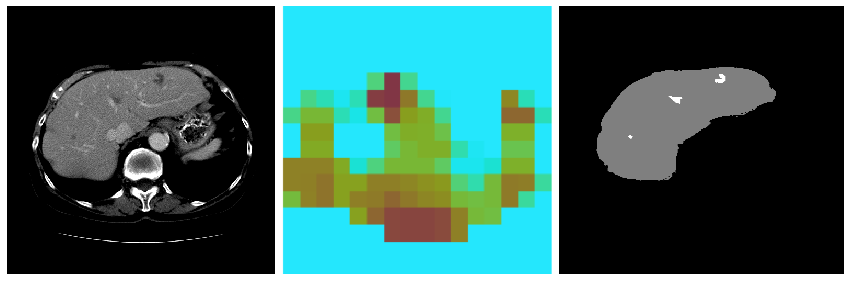

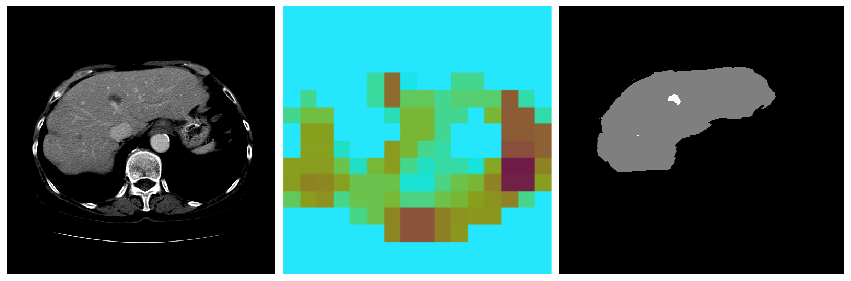

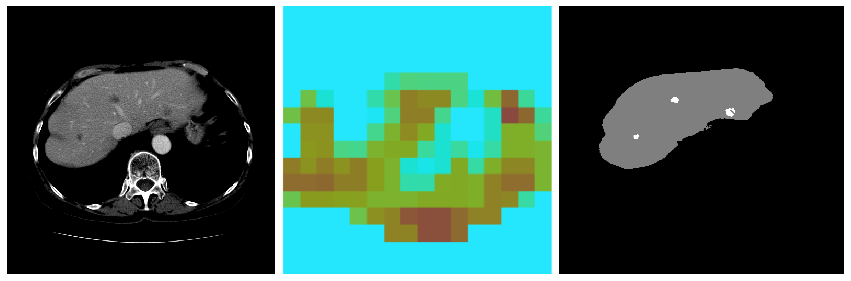

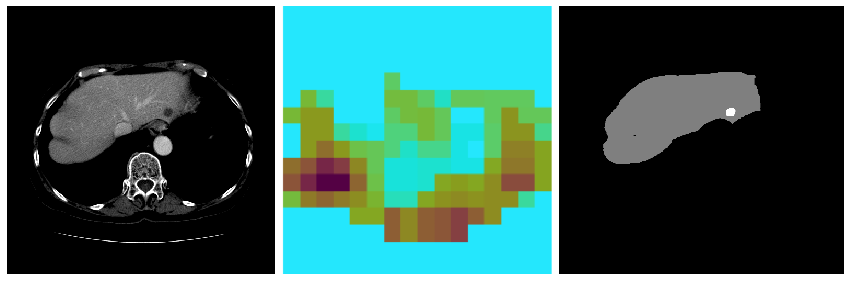

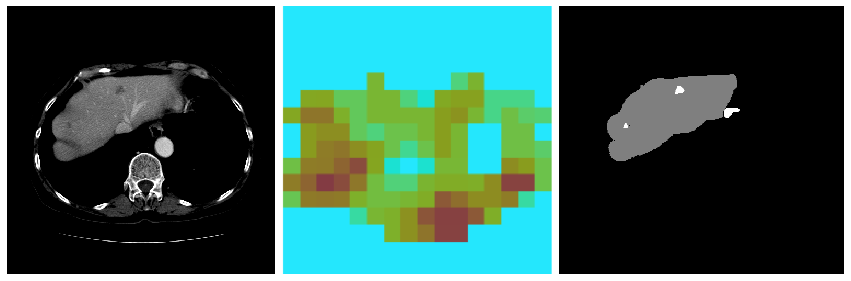

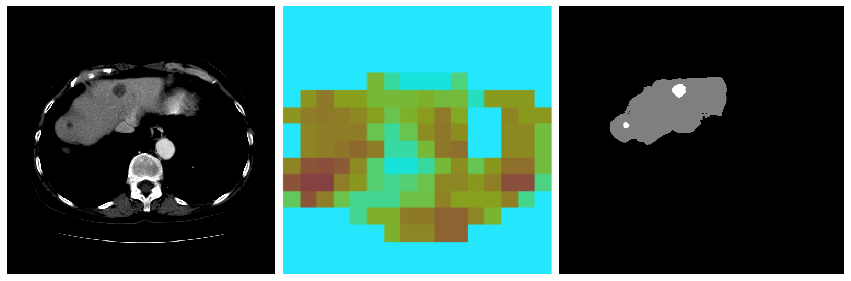

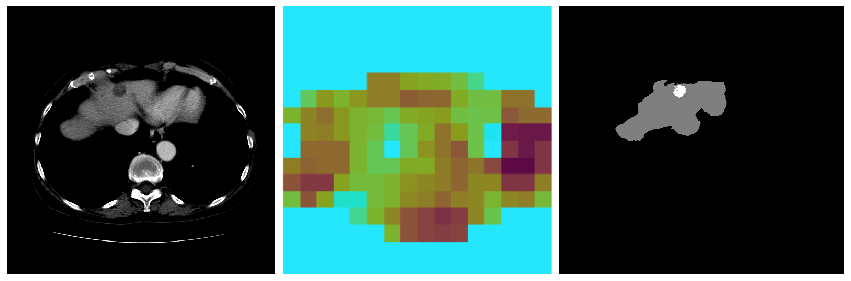

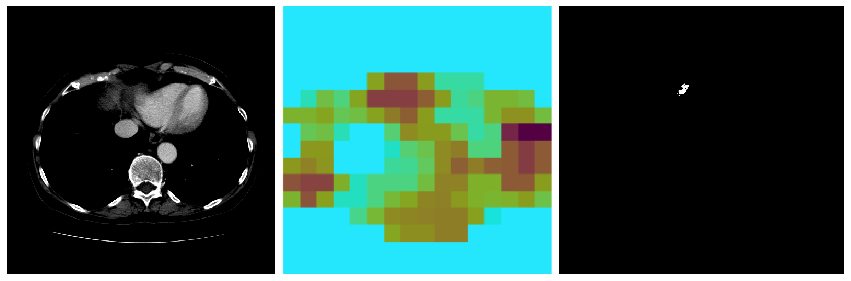

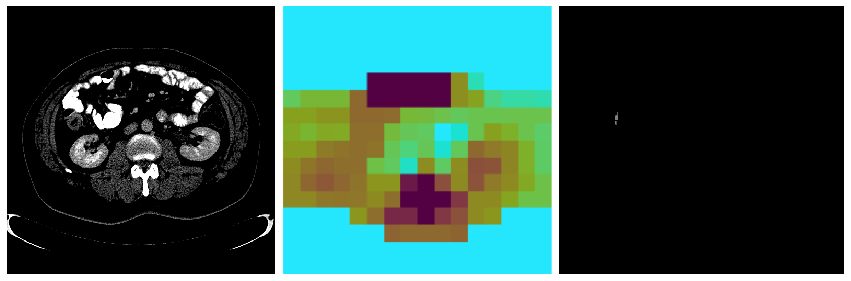

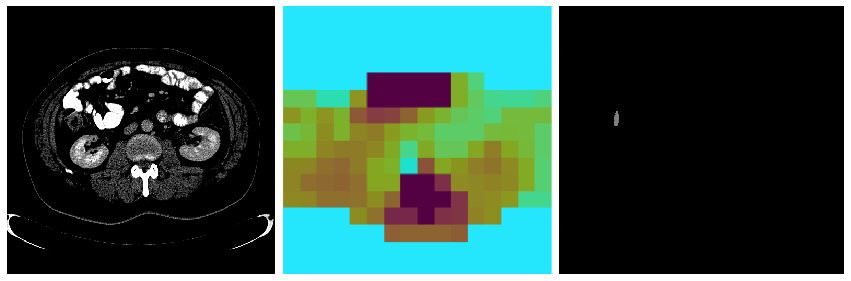

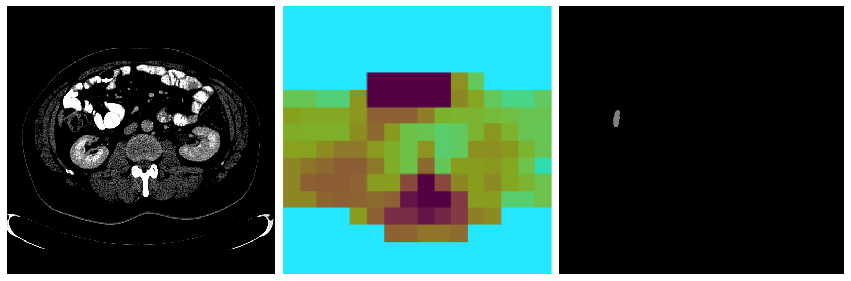

In [50]:
idx = 10
with torch.no_grad():
    for i, data in enumerate(test_dataloader):
        image, mask = data
        
        if device_ids:
            image = image.cuda(device_ids[0])
            
        with torch.no_grad():
            out = unet(image)
            scores = F.softmax(out, dim=1)

            segmentations = torch.round(F.threshold(scores[:, 1, :, :], 0.5, 0))
            processed_image = segmentations.unsqueeze(1) * image
        
        output, *_ = model(processed_image)
        
        #localize occluder
#         pdb.set_trace()
        score, occ_maps, part_scores = model.get_occlusion(image, 0)
        occ_map = occ_maps[0].detach().cpu().numpy()
        occ_map = cv2.medianBlur(occ_map.astype(np.float32), 3)
        occ_img = visualize_response_map(occ_map, tit='',cbarmax=0)
        
        # concatenate original image and occluder map
        img_orig = np.array(Image.fromarray(image_dataset[i], mode='F').convert('RGB'))
        mask = np.array(Image.fromarray(mask.squeeze().numpy()*255//2, mode='F').convert('RGB'))
        faco = img_orig.shape[0] / occ_img.shape[0]
        
        occ_img_s = cv2.resize(occ_img, (int(occ_img.shape[1] * faco), img_orig.shape[0]))
        mask = cv2.resize(mask, (int(occ_img.shape[1] * faco), img_orig.shape[0]))
        
        canvas = np.concatenate((img_orig, occ_img_s, mask), axis=1)
        plt.figure(figsize=(15, 15))
        plt.imshow(canvas)
        plt.axis('off')
        fp = f'CompositionalNets/results/lits/train_without_occluder/{i}.png'
        cv2.imwrite(fp, canvas)
#         print('Occlusion map written to: {}'.format(out_name))
        if i == idx: break

# Sanity Check

## UNet

### CHAOS

In [35]:
data_dir = os.path.join(directories['chaos'])
path_to_unet = os.path.join(directories['checkpoints'], unet_filename)
unet = UNet(pretrained=True)
unet.load_state_dict(torch.load(path_to_unet)['model_state_dict'])

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Grayscale(3),
    transforms.Resize((256, 256)),
    transforms.CenterCrop((224, 224)),
    transforms.ToTensor(),
])

with h5py.File(hdf5_path, 'r') as hf:
    image_dset = hf['images'][0:10]
    target_dset = hf['masks'][0:10]
    
dataset = ClassificationDataset(image_dset, target_dset, input_transform=transform)
dataloader = DataLoader(dataset, batch_size=4)

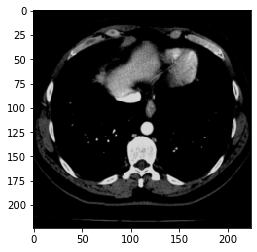

In [36]:
image, target = dataset[0]
plt.imshow(image.cpu().permute(1,2,0).numpy(), cmap="gray")

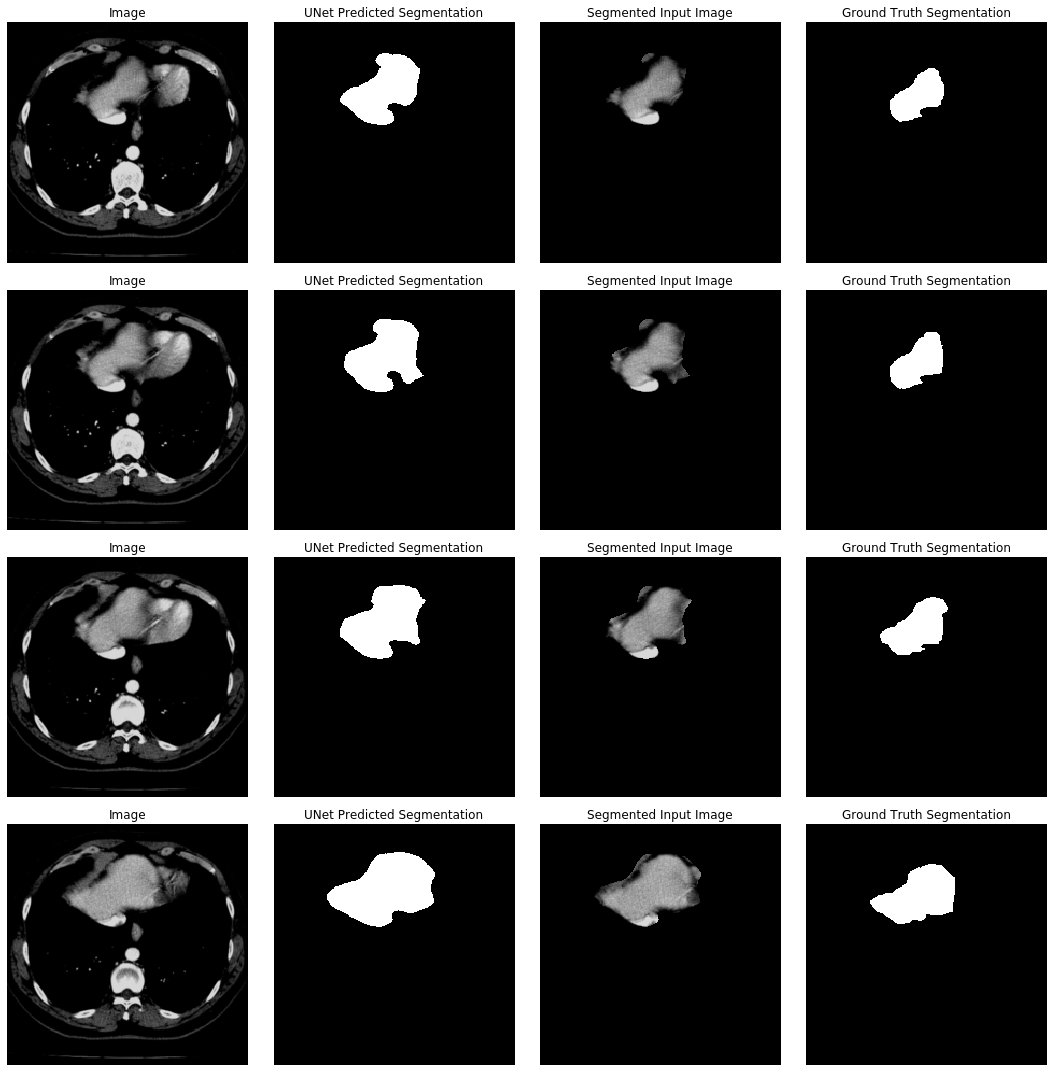

In [38]:
for images, targets in dataloader:
    with torch.no_grad():
        out = unet(images)
    break
scores = F.softmax(out, dim=1)
segmentation_maps = torch.round(F.threshold(scores[:, 1, :, :], 0.7, 0))
processed_images = segmentation_maps.unsqueeze(1) * images

fig, axes = plt.subplots(4, 4, figsize=(15, 15))
for i, axis in enumerate(axes):
    axis[0].set_title('Image')
    axis[0].imshow(images[i].squeeze().permute(1, 2, 0).cpu().numpy())
    axis[0].axis('off')
    axis[1].set_title('UNet Predicted Segmentation')
    axis[1].imshow(segmentation_maps[i].squeeze().cpu().numpy(), cmap='gray')
    axis[1].axis('off')
    axis[2].set_title('Segmented Input Image')
    axis[2].imshow(processed_images[i].squeeze().permute(1, 2, 0).cpu().numpy())
    axis[2].axis('off')
    axis[3].set_title('Ground Truth Segmentation')
    axis[3].imshow(targets[i], cmap='gray')
    axis[3].axis('off')
plt.tight_layout()
plt.show()

### LiTS

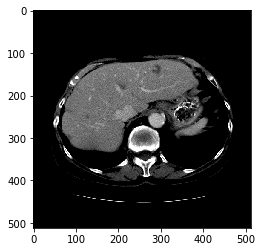

In [42]:
path_to_unet = os.path.join(directories['checkpoints'], unet_filename)
unet = UNet(pretrained=True)
unet.load_state_dict(torch.load(path_to_unet, map_location=torch.device('cpu'))['model_state_dict'])

train_hdf5_fp = os.path.join(directories['lits'], 'train.hdf5')
hf = h5py.File(train_hdf5_fp, 'r')
image_dset = hf['images'][50:80]
target_dset = hf['masks'][50:80]

lits_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Grayscale(3),
    transforms.ToTensor(),
    Resize((512, 512))
])

lits_dataset = ClassificationDataset(image_dset, target_dset, 
                                     input_transform=lits_transform)

lits_dataloader = DataLoader(lits_dataset, batch_size=4, pin_memory=False)

image, _ = lits_dataset[0]
plt.imshow(image.cpu().permute(1, 2, 0).numpy())

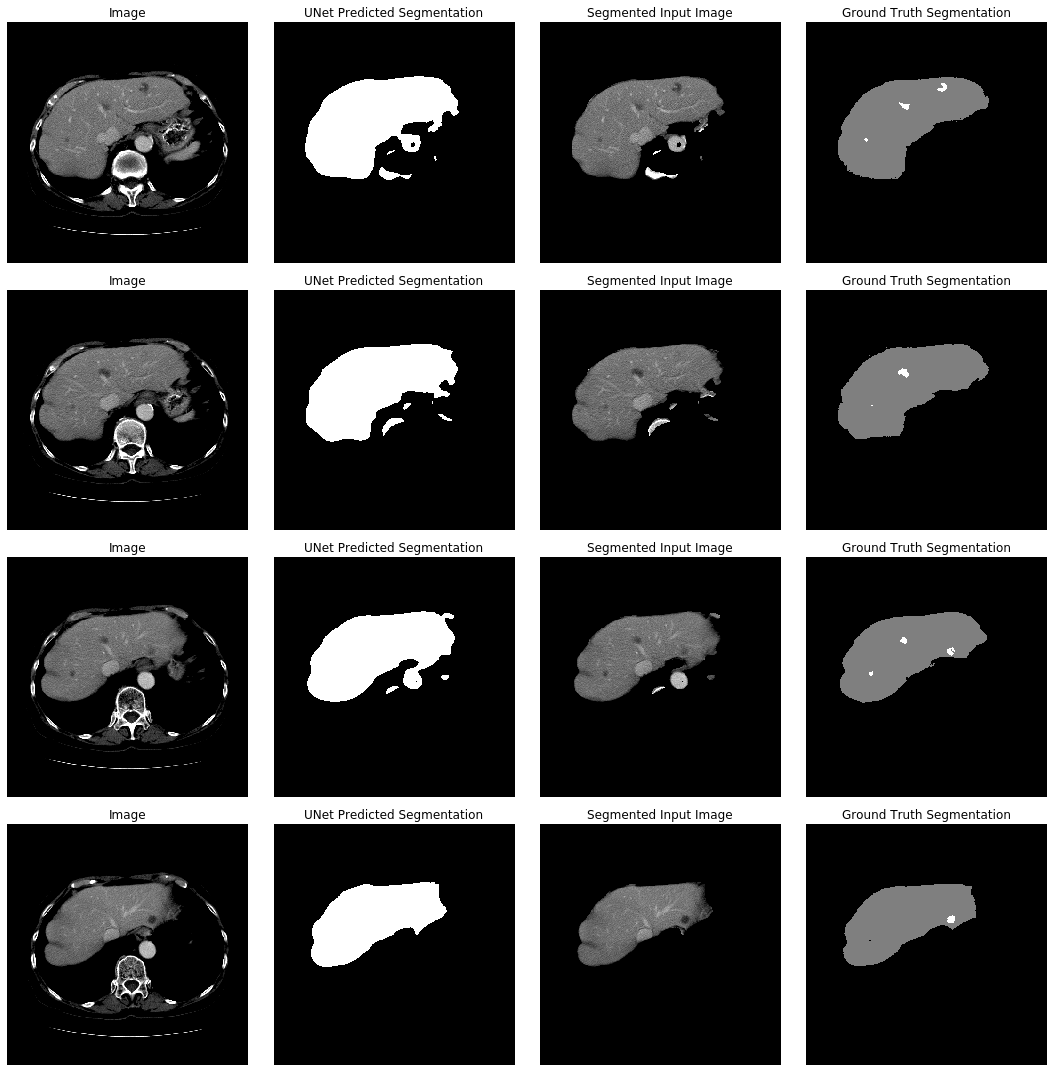

In [46]:
for images, targets in lits_dataloader:
    with torch.no_grad():
        out = unet(images)
    break
scores = F.softmax(out, dim=1)
segmentation_maps = torch.round(F.threshold(scores[:, 1, :, :], 0.7, 0))
processed_images = segmentation_maps.unsqueeze(1) * images

fig, axes = plt.subplots(4, 4, figsize=(15, 15))
for i, axis in enumerate(axes):
    axis[0].set_title('Image')
    axis[0].imshow(images[i].squeeze().permute(1, 2, 0).cpu().numpy())
    axis[0].axis('off')
    axis[1].set_title('UNet Predicted Segmentation')
    axis[1].imshow(segmentation_maps[i].squeeze().cpu().numpy(), cmap='gray')
    axis[1].axis('off')
    axis[2].set_title('Segmented Input Image')
    axis[2].imshow(processed_images[i].squeeze().permute(1, 2, 0).cpu().numpy())
    axis[2].axis('off')
    axis[3].set_title('Ground Truth Segmentation')
    axis[3].imshow(targets[i]*255//2, cmap='gray')
    axis[3].axis('off')
plt.tight_layout()
plt.show()

## CompNet

In [4]:
import torch
import numpy as np
from torch.utils.data import DataLoader
from Code.config import categories, categories_train, dataset, data_path, device_ids, mix_model_path, dict_dir, layer, vMF_kappa, model_save_dir, compnet_type, backbone_type, num_mixtures
from Code.config import config as cfg
from Code.model import Net
from Code.helpers import Imgset, imgLoader, getVmfKernels, getCompositionModel, update_clutter_model
from Code.eval_occlusion_localization import visualize_response_map
import tqdm
import torchvision.models as models
import cv2
import pdb

In [3]:
def test():
    ###################
    # Test parameters #
    ###################
    likely = 0.6  # occlusion likelihood
    bool_load_pretrained_model = True
    bool_mixture_model_bg = False 	# use maximal mixture model or sum of all mixture models, not so important
    bool_multi_stage_model = False 	# this is an old setup

    occ_likely = []
    for i in range(len(categories_train)):
        occ_likely.append(0.6)
    ############################
    # Get CompositionalNet Init
    ############################
    # get pool5 feature extractor
    extractor = models.vgg16(pretrained=True).features
    extractor.cuda(device_ids[0]).eval()
    weights = getVmfKernels(dict_dir, device_ids)
    
    mix_models = getCompositionModel(device_ids, mix_model_path, layer, categories_train,compnet_type=compnet_type,num_mixtures=num_mixtures)
    net = Net(extractor, weights, vMF_kappa, occ_likely, mix_models, bool_mixture_bg=bool_mixture_model_bg,compnet_type=compnet_type, num_mixtures=num_mixtures, vc_thresholds=cfg.MODEL.VC_THRESHOLD)
    
    if device_ids:
        net = net.cuda(device_ids[0])
    pretrained_model = model_save_dir+'vgg_pool5_p3d+/best.pth'
    if device_ids:
        load_dict = torch.load(pretrained_model, map_location='cuda:{}'.format(device_ids[0]))
    else:
        load_dict = torch.load(pretrained_model, map_location='cpu')
    net.load_state_dict(load_dict['state_dict'])
    if device_ids:
        net = net.cuda(device_ids[0])
    updated_clutter = update_clutter_model(net,device_ids)
    net.clutter_model = updated_clutter

    ########################################################
    # Classify image and extract occluder locations
    ########################################################

    test_imgs = []
    test_imgs.append('CompositionalNets/demo/17029_0_val2017.jpg')
    test_imgs.append('CompositionalNets/demo/81819_0_train2017.jpg')
    test_imgs.append('CompositionalNets/demo/487059_4_train2017.jpg')

    test_imgset = Imgset(test_imgs, [[''],[''],['']], [5,4,8], imgLoader, bool_square_images=False)

    test_loader = DataLoader(dataset=test_imgset, batch_size=1, shuffle=False)

    with torch.no_grad():
        for i, data in enumerate(test_loader):
            #load data
            input, mask, label = data
            if device_ids:
                input = input.cuda(device_ids[0])
            c_label = label.numpy()
            img_name = test_loader.dataset.images[i]
            #classify
            output, *_ = net(input)
            out = output.cpu().numpy().argmax(-1)[0]
            pred_class = categories_train[out]
            print('\nImage {} classified as {}'.format(img_name,pred_class))
            #localize occluder
            score, occ_maps, part_scores = net.get_occlusion(input, label)
            occ_map = occ_maps[0].detach().cpu().numpy()
            occ_map = cv2.medianBlur(occ_map.astype(np.float32), 3)
            occ_img = visualize_response_map(occ_map, tit='',cbarmax=0)
            # concatenate original image and occluder map
            img_orig = cv2.imread(img_name)
            faco = img_orig.shape[0] / occ_img.shape[0]
            occ_img_s = cv2.resize(occ_img, (int(occ_img.shape[1] * faco), img_orig.shape[0]))
            out_name = 'CompositionalNets/demo/{}_predclass_{}_and_occluder_map.jpg'.format(img_name.split('/')[1].split('.')[0],pred_class)
            canvas = np.concatenate((img_orig, occ_img_s), axis=1)
            cv2.imwrite(out_name, canvas)
            print('Occlusion map written to: {}'.format(out_name))

In [4]:
test()

> <ipython-input-3-b5aac844608e>(22)test()
-> net = Net(extractor, weights, vMF_kappa, occ_likely, mix_models, bool_mixture_bg=bool_mixture_model_bg,compnet_type=compnet_type, num_mixtures=num_mixtures, vc_thresholds=cfg.MODEL.VC_THRESHOLD)


(Pdb)  c



Image CompositionalNets/demo/17029_0_val2017.jpg classified as car


/pytorch/aten/src/ATen/native/BinaryOps.cpp:81: UserWarning: Integer division of tensors using div or / is deprecated, and in a future release div will perform true division as in Python 3. Use true_divide or floor_divide (// in Python) instead.


Occlusion map written to: CompositionalNets/demo/demo_predclass_car_and_occluder_map.jpg

Image CompositionalNets/demo/81819_0_train2017.jpg classified as bus
Occlusion map written to: CompositionalNets/demo/demo_predclass_bus_and_occluder_map.jpg

Image CompositionalNets/demo/487059_4_train2017.jpg classified as motorbike
Occlusion map written to: CompositionalNets/demo/demo_predclass_motorbike_and_occluder_map.jpg


In [ ]:
params = {
        "lr": 0.0001,
        "batch_size": 8,
        "split_train_val": 0.8,
        "epochs": 50,
        "use_dice_loss": False,
        "cache": True,
        "random_seed": 42,
        "shuffle_data": True,
        "scheduler": "StepLR",
        "step_size": 15,
        "gamma": 0.75,
        "threshold": 0.7,
        "pretrained": True,
    }

train_dataloader = DataLoader(train_dataset, batch_size=params['batch_size'])

# Instantiate model, optimizer, and criterion
unet = UNet(dice=params['use_dice_loss'], pretrained=params['pretrained'])
if is_cuda_available: unet = unet.to(device, dtype=input_images_dtype)

optimizer = optim.Adam(unet.parameters(), lr=params['lr'])
if params['scheduler'] == 'StepLR': 
    scheduler = optim.lr_scheduler.StepLR(optimizer, 
                                          step_size=params['step_size'], gamma=params['gamma'])
elif params['scheduler'] == 'ReduceLROnPlateau':
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer)

loss_weight = torch.DoubleTensor(1 - target_dist)
if is_cuda_available: loss_weight = loss_weight.to(device, num_classes=3)
criterion = dice_loss if params['use_dice_loss'] else CrossEntropyLoss(weight=loss_weight,
                                                                       reduction='mean')

num_accumulated_steps = 128 // params['batch_size']